In [58]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [59]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [60]:
train_data = pd.read_csv("train.csv")

In [85]:
train_data[train_data["threat"]==1][:10]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79,003217c3eb469ba9,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1
600,0199d6af27b715f3,I'm also a sock puppet of this account...SUPRI...,1,0,0,1,0,0
802,02230885017a50c5,"Fuck you, Smith. Please have me notified when ...",1,0,1,1,1,0
1017,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,1,1,1,1,1
1085,02f77830b4d71c0f,Whoever put a notices on my page. I will kill u,1,0,0,1,0,0
1312,039296aa294ee10b,"SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!",1,1,1,1,1,1
1535,0420f5f4e950566b,Demonte Morton \n\nU bastard stop deletin' my ...,1,0,1,1,1,1
1878,0512f33cf8807fa2,Aaron Swartz \n\nStop fucking reverting my god...,1,0,1,1,1,1
2018,057894cf4738a5d8,You are a gay homo. I hope you choke on your p...,1,0,1,1,1,1


(array([126021.,  20285.,   6626.,   2605.,   1200.,    736.,    569.,
           490.,    397.,    642.]),
 array([   6. ,  505.4, 1004.8, 1504.2, 2003.6, 2503. , 3002.4, 3501.8,
        4001.2, 4500.6, 5000. ]),
 <BarContainer object of 10 artists>)

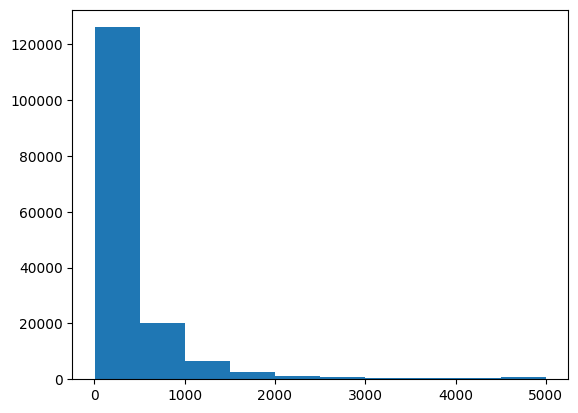

In [62]:
plt.hist([len(i) for i in train_data["comment_text"]])

<BarContainer object of 6 artists>

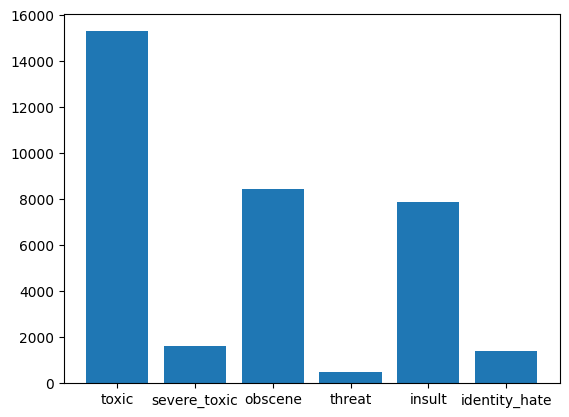

In [63]:
x = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
y = [len([j for j in train_data[i] if j==1]) for i in x]
plt.bar(x,y)

In [64]:
train_data[train_data["id"] == "006b94add72ed61c"]["comment_text"]

176    I think that your a Fagget get a oife and burn...
Name: comment_text, dtype: object

### Preprocessing

In [65]:
from tensorflow.keras.layers import TextVectorization ##This will hwlp in tokeinizing the sentences

In [66]:
x = train_data["comment_text"]
y = train_data[train_data.columns[2:]].values
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [67]:
MAX_FEATURES = 200000 #Number of words in vocab

In [68]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [69]:
vectorizer.adapt(x.values)
vectorized_text = vectorizer(x.values)

In [70]:
#MCSHBAP: map, cache, shuffle, batch, prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(8)#Prevents bottleneck
dataset.as_numpy_iterator().next()

(array([[   8,   72,    7, ...,    0,    0,    0],
        [ 257, 1562,  156, ...,    0,    0,    0],
        [1856,    9, 3309, ...,    0,    0,    0],
        ...,
        [  46,   33,   15, ...,    0,    0,    0],
        [3168,    3, 4026, ...,    0,    0,    0],
        [   8,   51, 1295, ...,    0,    0,    0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
       

In [71]:
x_batch, y_batch = dataset.as_numpy_iterator().next()
x_batch.shape,y_batch.shape

((32, 1800), (32, 6))

In [72]:
train = dataset.take(int(len(dataset)*0.8)+1)
val = dataset.skip(int(len(dataset)*0.8)+1).take(int(len(dataset)*0.2))

### Model Creation (Bidirectional LSTM)


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding

In [74]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation = "tanh")))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(6, activation="sigmoid"))

In [75]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 256)               16640     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                                 
Total params: 6466982 (24.67 MB)
Trainable params: 6466982 (24.67 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [76]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
               optimizer="adam",
               metrics=["accuracy"])

In [77]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)
model_history = model.fit(x = train,
                            epochs=10,
                            validation_data=val,
                          callbacks = [stop_early]
                            )

Epoch 1/10


2023-08-11 11:26:36.864232: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3990/3990 [==============================] - 452s 111ms/step - loss: 0.0636 - accuracy: 0.9880 - val_loss: 0.0451 - val_accuracy: 0.9939
Epoch 2/10
3990/3990 [==============================] - 360s 89ms/step - loss: 0.0447 - accuracy: 0.9902 - val_loss: 0.0386 - val_accuracy: 0.9943
Epoch 3/10
3990/3990 [==============================] - 337s 84ms/step - loss: 0.0391 - accuracy: 0.9827 - val_loss: 0.0345 - val_accuracy: 0.9939
Epoch 4/10
3990/3990 [==============================] - 340s 85ms/step - loss: 0.0336 - accuracy: 0.9886 - val_loss: 0.0277 - val_accuracy: 0.9943
Epoch 5/10
3990/3990 [==============================] - 356s 89ms/step - loss: 0.0295 - accuracy: 0.9927 - val_loss: 0.0258 - val_accuracy: 0.9921
Epoch 6/10
3990/3990 [==============================] - 335s 84ms/step - loss: 0.0253 - accuracy: 0.9802 - val_loss: 0.0207 - val_accuracy: 0.9949
Epoch 7/10
3990/3990 [==============================] - 335s 84ms/step - loss: 0.0216 - accuracy: 0.9624 - val_loss: 0.0169 - va

In [78]:
model.save("LSTM-Model")

INFO:tensorflow:Assets written to: LSTM-Model/assets


INFO:tensorflow:Assets written to: LSTM-Model/assets


### Using the model to predict

In [79]:
model1 = tf.keras.models.load_model('LSTM-Model')

In [80]:
input_text = vectorizer("I will kill you and your entire family.")

In [81]:
res = model1.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 2s 2s/step


In [82]:
output = (res>0.5).astype(int)

In [83]:
col = train_data.columns[2:]
col = col.to_numpy()
col.shape

(6,)

In [84]:
count = 0
for index,element in np.ndenumerate(output):
  if(element==1):
    count = count+1
    _,k = index
    print(col[k])
if(count==0):
  print("Not Toxic")

toxic
threat
